In [2]:
import sys
sys.path.insert(0, '/home/ashwin1996/FLD_optimal_weighting')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
from tfld import tfld, utils
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm, multivariate_normal, invwishart, wishart
from sklearn.metrics import balanced_accuracy_score as bas
from numpy.linalg import inv

from joblib import Parallel, delayed
from tqdm import tqdm

In [32]:
# essential functions; from Ashwin's code
def generate_data(n, nu, d, cov, pi):
    "Draw data from the target distribution"
    n_1 = round(n*pi)
    n_0 = round(n*(1-pi))
    X_0 = np.random.multivariate_normal(-nu, cov, n_0)
    X_1 = np.random.multivariate_normal(nu, cov, n_1)
    X = np.concatenate((X_0, X_1), axis=0)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def create_dataset(n, nu, d, cov, pi=0.5, seed=None):
    "Draw data from the target distribution under a specified seed"
    if seed is not None:
        np.random.seed(seed)
    X, Y = generate_data(n, nu, d, cov, pi)
    return X, Y

def train_fld(X, y, cov, estimate_cov=True):
    "Train the FLD on the target data (return the learnt projection vector, covariance estimate, and target class 1 mean (nu^(0)) estimate"
    X_1 = X[y==1]
    X_0 = X[y==0]

    # estimate class means
    m_0 = np.mean(X_0, axis=0)
    m_1 = np.mean(X_1, axis=0)

    # estimate class covariance matrices
    if estimate_cov:
        n_0, n_1 = len(X_0), len(X_1)
        cov_0 = np.cov(X_0, rowvar=False)
        cov_1 = np.cov(X_1, rowvar=False)
        cov = ((n_0 - 1) * cov_0 + (n_1 - 1) * cov_1) / (n_0 + n_1 - 2) # pooled variance
    
    # estimate class priors
    p = len(y[y==1])/len(y)

    # estimate projection and threshold terms
    w_0 = np.linalg.pinv(2 * cov) @ (m_1 - m_0)
    w_0 /= np.linalg.norm(w_0, 2)
    c_0 = 2 * np.log((1-p)/p)
    nu_hat = (m_1 - m_0)/2

    return w_0, c_0, cov, nu_hat 

def get_target_variance(n, mu, cov):
    mu = mu.reshape(len(mu), 1)
    inv_cov = np.linalg.pinv(cov)
    cov_w = ((1 + mu.T @ inv_cov @ mu) * inv_cov - inv_cov @ mu @ mu.T @ inv_cov) / n
    return cov_w
    
def get_covariance(d, seed=1996):
    cov = wishart.rvs(10, np.eye(d), 1, random_state=seed)
    return cov

In [39]:
d = 10
nu = np.zeros(d)
nu[0] = 1
cov = get_covariance(d, 1996)
pi = 0.5
n_list = [10, 100, 1000, 10000]
num_reps = 1000

def generate_proj_vectors(n, nu, d, cov, pi, estimate_cov=True):
    X, y = create_dataset(n, nu, d, cov, pi=0.5, seed=None)
    w, _, _, _ = train_fld(X, y, cov, estimate_cov)
    return w

def get_plugin_nu_and_cov(n, nu, d, cov, pi, estimate_cov=True):
    X, y = create_dataset(n, nu, d, cov, pi=0.5, seed=None)
    _, _, cov_hat, nu_hat = train_fld(X, y, cov, estimate_cov)
    return cov_hat, nu_hat

err_list = np.zeros((3, len(n_list)))
for i, n in enumerate(n_list):
    asym_cov = get_target_variance(n, nu, cov) # asym cov with true nu, sigma
    cov_hat, nu_hat = get_plugin_nu_and_cov(n, nu, d, cov, pi, estimate_cov=True)
    asym_cov_plugin = get_target_variance(n, nu_hat, cov_hat) # asym cov with plugin nu, sigma

    f = lambda : generate_proj_vectors(n, nu, d, cov, pi)
    w_list = np.array(Parallel(n_jobs=-1)(delayed(f)() for rep in range(num_reps)))
    true_cov = np.cov(w_list, rowvar=False) # true cov from MC reps

    err_list[0, i] = np.linalg.norm(asym_cov, ord='fro')
    err_list[1, i] = np.linalg.norm(asym_cov_plugin, ord='fro')
    err_list[2, i] = np.linalg.norm(true_cov, ord='fro')

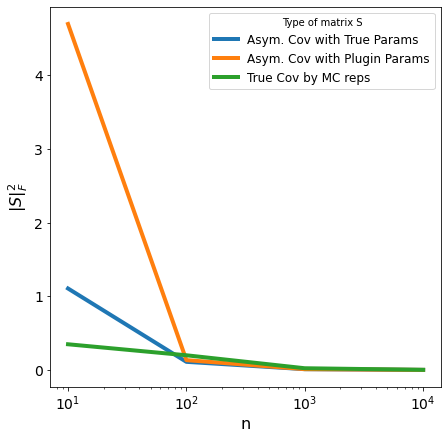

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 7))
labels = ["Asym. Cov with True Params", 
          "Asym. Cov with Plugin Params",
          "True Cov by MC reps"]
for i in range(len(err_list)):
    ax.plot(n_list, err_list[i, :], lw=4, label=labels[i])
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel(r"$\| S \|^2_F$", fontsize=16)
ax.set_xlabel("n", fontsize=16)
ax.legend(title="Type of matrix S", fontsize=14)